Statistics (I)(2) Final Project
===

<font face="微軟正黑體">
<b>組長</b> : 劉鎮霆 B07705015 <br>
<b>組員</b> : 黃煒勛 B07705010 | 黃　心 B07705013 | 康　崴 B07705014 | 張宇承 B07705017 | 李旻叡 B07705037
</font>

讀取函式庫

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
pd.options.display.max_rows = 999

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels
import statsmodels.stats.outliers_influence as sso

## <center>Table of Contents</center>

---

[<center><font face="微軟正黑體">分析主題</font></center>](#分析主題)
[<center><font face="微軟正黑體">前言</font></center>](#前言)
[<center><font face="微軟正黑體">敘述統計 & 視覺化</font></center>](#敘述統計-&-視覺化)
[<center><font face="微軟正黑體">迴歸分析</font></center>](#迴歸分析)
[<center><font face="微軟正黑體">假設檢定</font></center>](#假設檢定)
[<center><font face="微軟正黑體">結論與建議</font></center>](#結論與建議)

---


**<font face="微軟正黑體">分析主題</font>**
---

Spotify 串流平台中歌曲特性對熱門程度的影響

**<font face="微軟正黑體">前言</font>**
---

　　現今社會串流音樂蔚為主流，全世界有數億人在使用這類的服務。而在眾多的串流服務中又以 Spotify 為箇中翹楚，它有著 2.86 億個使用者，想必各個音樂發行商的競爭也是十分激烈。我們這些平時熱愛音樂的學生不禁好奇，一首歌要有怎麼樣的特性才可以在 Spotify 的使用環境中脫穎而出，得到較高的熱門程度。若是知道熱門程度與歌曲各項特性的關係，或許發行商可以根據此關係調整策略，獲得較高的觸及率和收益。我們先由敘述統計觀察不同曲風熱門程度分佈，接著做回歸分析發現曲風影響熱門程度，最後由假設檢定看曲風的差異性是怎麼決定熱門程度以及曲風之間哪些特性有差異。

**<font face="微軟正黑體">資料集</font>**
---

### 1. **<font face="微軟正黑體">資料蒐集</font>**

　　我們首先在 kaggle 上找到 [Spotify 歌曲資料集](https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db)，其中包含了每一首歌的歌曲類型、歌手、流行度 (popularity)、原聲性 (acousticness) 等數據。由於 kaggle 上的資料比較舊 (2019 年 3 月)，再加上其中的歌曲類型有經過人為處理 (例如將 kids 與 children 合併為一種類型)，因此我們決定參考它蒐集資料的方法，重新蒐集歌曲資料。<br>
　　抽樣時，我們採用 stratified sampling，透過 Soptipy 函式庫搜尋 Spotify 上各個類型的歌曲 (會回傳歌曲資料的 list)，再各自隨機抽樣出 100 首歌，程式碼如下：<br>
(由於不同時間的搜尋結果會不一樣，因此即使設定相同的 random seeds 也無法 reproduce，因此底下只是展示 api 的程式碼)

<font face="微軟正黑體">
    取得授權 (考量安全性問題，我們將用戶資料以 dictionary 的形式存在 <b>auth.npy</b>，資料的取得方式見此
    <a href='https://developer.spotify.com/documentation/general/guides/app-settings/'>連結</a>)
</font>

In [2]:
auth = np.load('auth.npy', allow_pickle=True)
os.environ["SPOTIPY_CLIENT_ID"] = auth.item().get('id')
os.environ["SPOTIPY_CLIENT_SECRET"] = auth.item().get('secret')
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(requests_timeout=None))

FileNotFoundError: [Errno 2] No such file or directory: 'auth.npy'

定義搜尋歌曲的函數

In [ ]:
def search_genre(genre, offset=0, max_n=None):
    if max_n is None:
        max_n = sp.search(q=f'genre:"{genre}"', offset=0, limit=1, type='track').get('tracks').get('total')
    if max_n <= 50:
        search = sp.search(q=f'genre:"{genre}"', offset=offset, limit=max_n, type='track').get('tracks')
    else:
        search = {}
        search['total'] = 0
        search['items'] = []
        while search['total'] < max_n:
            step = search['total']+1
            print(f'\r[{step}/{max_n}] (search)', end='')
            num = min(50, max_n-search['total'])
            try:
                tmp = sp.search(q=f'genre:"{genre}"', offset=offset+search['total'], limit=num, type='track').get('tracks')
            except:
                break
            search['items'].extend(tmp.get('items'))
            search['total'] += len(tmp.get('items'))
    return search

def crawl(genres):
    variables = ['id', 
                 'name', 
                 'genre', 
                 'url', 
                 'popularity', 
                 'acousticness', 
                 'danceability',
                 'energy',
                 'instrumentalness',
                 'liveness',
                 'speechiness',
                 'duration_ms',
                 'key',
                 'loudness',
                 'mode',
                 'tempo',
                 'valence',
                 'available_market',
                 'release_date',
                 'explicit']
    columns = {v:[] for v in variables}
    data = pd.DataFrame(data=columns)
    for i, genre in enumerate(genres):
        n = sp.search(q=f'genre:"{genre}"', offset=0, limit=1, type='track').get('tracks').get('total')
        if n == 0:
            continue
        offsets = random.sample(list(np.arange(min(n-1, 1999))), k=min(n, 100))
        for j, offset in enumerate(offsets):
            print(f'\r[{j+1}/{len(offsets)}] (process)', end='')
            items = search_genre(genre, offset=offset, max_n=1).get('items')
            if items is None:
                continue
            result = items[0]
            feature = sp.audio_features(result.get('id'))[0]
            row = {
                'id': result.get('id') or '', 
                'name': result.get('name') or '', 
                'genre': genre, 
                'url': result.get('external_urls').get('spotify') or result.get('external_urls').get(list(result.get('external_urls').keys())[0]) or '',
                'popularity': result.get('popularity'),
                'available_market': len(result.get('available_markets')),
                'duration_ms': result.get('duration_ms'),
                'explicit': result.get('explicit'), # has explicit lyrics
                'release_date': result.get('album').get('release_date'),
                'acousticness': feature.get('acousticness'), 
                'danceability': feature.get('danceability'),
                'energy': feature.get('energy'),
                'instrumentalness': feature.get('instrumentalness'),
                'liveness': feature.get('liveness'),
                'speechiness': feature.get('speechiness'),
                'key': feature.get('key'),
                'loudness': feature.get('loudness'),
                'mode': feature.get('mode'),
                'tempo': feature.get('tempo'),
                'valence': feature.get('valence')
            }
            
            data = data.append(row, ignore_index=True)
        print(f'\r[{i+1}/{len(genres)}] genre: {genre}'.rjust(20, ' '))
    return data

開始搜尋，每項歌曲類型取 100 首歌

In [ ]:
random.seed(113)
np.random.seed(113)
allGenres = sp.recommendation_genre_seeds()['genres']
data = crawl(allGenres)

檢查搜尋結果

In [ ]:
data['idx'] = data.index
print('head:')
display(data.head())
print(f'genre counts: {len(data["genre"].unique())}')
print('genre:')
print(data['genre'].unique())

我們可以看出 126 項歌曲類型中，有 112 項爬取成功，接著檢查每項歌曲種類成功爬取的歌曲數

In [ ]:
data['genre'].value_counts()

112 項歌曲種類皆爬取 100 首歌，我們先將資料存取起來

In [ ]:
data.to_csv('example.csv', encoding="utf-8", index=False)

由於有些歌可能同時被歸類在多種歌曲類型，因此我們需要刪除重複的項目，在這裡我們使用 `random.randint` 函數隨機選取要留下的歌曲

In [ ]:
data = pd.read_csv('example.csv', encoding="utf-8", index_col=False)
duplicates = data['id'].value_counts()[data['id'].value_counts() > 1].index
tmp = data.loc[[n in duplicates for n in data['id']]]
tmp = tmp.sort_values(by=['id', 'idx'])

random.seed(113)
n = len(tmp['id'].unique())
for i, ID in enumerate(tmp['id'].unique()):
    print(f'[{i+1}/{n}]', end='\r')
    remove = tmp[tmp['id'] == ID]['idx'].values
    leave = random.randint(0, len(tmp[tmp['id'] == ID])-1)
    remove = np.delete(remove, leave)
    data = data[[i not in remove for i in data['idx']]]
print('Head of data:')
display(data.head())

In [ ]:
data.to_csv('example_no_duplicate.csv', encoding="utf-8", index=False)

接著，我們發現 2020 年 5 月份以後的熱門度普遍偏低，且分布呈現 right-skewed，有可能是因為 Spotify 使用歌曲的總播放數與近期播放數衡量它的熱門程度，導致新出的歌曲熱門度不高，如下：

In [ ]:
data = pd.read_csv('example_no_duplicate.csv', encoding="utf-8", index_col=False)
data['popularity'].hist()
plt.title('Popularity All the Time')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
data.loc[np.array([d < '2020-05' for d in data['release_date']]), 'popularity'].hist(ax=axs[0])
axs[0].set_title('Popularity Before May, 2020')
axs[0].set_xlabel('Popularity')
axs[0].set_ylabel('Frequency')
data.loc[np.array([d >= '2020-05' for d in data['release_date']]), 'popularity'].hist(ax=axs[1])
axs[1].set_title('Popularity After May, 2020')
axs[1].set_xlabel('Popularity')
axs[1].set_ylabel('Frequency')
plt.show()

基於以上因素，我們認為 2020 年 5 月以後歌曲的熱門程度可能沒辦法代表這首歌真實的熱門度，因此我們選擇將這些歌曲移除，並檢查移除後每個歌曲類型剩下的歌曲數

In [ ]:
data = data.iloc[np.array(data['release_date'] < '2020-05'), :]
data['genre'].value_counts()

可以發現大多數歌曲都還有 70 首以上的歌，但是 german 與 classical 的歌只剩下 26 首與 3 首

將資料存取起來

In [ ]:
data.to_csv('example_no_may.csv', encoding="utf-8", index=False)

### 2. **<font face="微軟正黑體">欄位介紹</font>**

In [3]:
df = pd.read_csv("tracks.csv")

- name: 歌曲名稱<br>
- available_market: 歌曲在多少地區可以被取得<br>
- explicit: 是否有明確的歌詞 (由提供者標示)<br>
- genre: 歌曲種類，共 112 種 (每種各 100 首歌)<br>
- popularity: 流行程度，數值範圍為 0到100。評分標準主要基於播放總數及近期播放數。一般來說，最近常播放的歌曲比過去常播放的歌曲有更高的流行度。<br>
- acousticness: 原聲性，數值範圍為 0到1。1 代表有很高的信心認定這首歌是不經過電子音效處理，可以聽到最直接的樂音及人聲。<br>
- danceability: 舞蹈性，數值範圍為 0到1。根據拍子、節奏和整體規律來決定是否適合跳舞。<br>
- duration_ms: 歌曲長度，以毫秒為單位。<br>
- energy: 能量，數值範圍為 0到1。代表感受上的強度與活力。一般來說，從有能量的歌曲會感受到快、大聲與嘈雜，而評分的特徵包含dynamic range、 perceived loudness, timbre, onset rate, 和general entropy。<br>
- instrumentalness: 樂器性，數值範圍為 0到1。偵測歌曲是否沒有人聲 (哼唱算樂器，而說唱或言語則為人聲)，此數值 >0.5 即可代表純樂器，不過越接近 1 信心水準越高。<br>
- key: 調，代表不同 standard Pitch Class notation，如 0=C, 1=C♯/D♭, 2=D，若無則為-1。<br>
- liveness: 數值範圍為 0到1。越高代表現場演奏的可能性高，>0.8表示極有可能為現場演奏。<br>
- loudness: 歌曲整體的響度，單位為分貝 (dB)，數值為整首歌的平均值，大部分在 -60至0。<br>
- mode: 調式，大調為1，小調為0。<br>
- speechiness: 言語性，數值範圍為 0到1。越接近純粹的言語 (如:脫口秀、有聲書、誦詩)，此數值越接近 1，>0.66 代表很有可能皆為言語所構成，0.33到0.66 則可能有部分為言語(如:說唱)，<0.33 為音樂或其他非言語性歌曲。<br>
- tempo: 節奏，單位為 beats per minute (BPM)。<br>
- valence: 正向性，數值範圍為 0到1，較高代表此音樂聽起來較為正面，較低則為負面。

**<font face="微軟正黑體">敘述統計 & 視覺化</font>**
---

### 1. **<font face="微軟正黑體">歌曲類型選擇與熱門度觀察</font>**

In [4]:
cato = [ 'j-pop', 'k-pop', 'hip-hop','country', 'dance', 'jazz', 'pop', 'blues']

讀取我們這次使用的資料，此份資料於 2020 年 5 月 14 日爬取

In [5]:
df = pd.read_csv("tracks.csv", encoding="utf-8", index_col=False)
print('Head of dataset:')
display(df.head())
print('Tail of dataset:')
display(df.tail())

Head of dataset:


,id,name,genre,url,popularity,acousticness,danceability,energy,instrumentalness,liveness,...,duration_ms,key,loudness,mode,tempo,valence,available_market,release_date,explicit,idx
0,5OpjJ9qy54D3PzQJ1s4Q9X,TESTIFY,acoustic,https://open.spotify.com/track/5OpjJ9qy54D3PzQ...,59.0,0.471,0.495,0.710,0.000000,0.0703,...,243800.0,0.0,-3.941,1.0,90.024,0.319,79.0,2016-07-15,0.0,0
1,6ZgaHk6yrHBbHrbTmKl2pZ,Learned A Lot,acoustic,https://open.spotify.com/track/6ZgaHk6yrHBbHrb...,39.0,0.850,0.556,0.285,0.068000,0.1090,...,270786.0,0.0,-9.884,1.0,128.167,0.322,78.0,2011,0.0,1
2,4wQKyYfNDY7E8ybcp0hF61,Jupiter's Call,acoustic,https://open.spotify.com/track/4wQKyYfNDY7E8yb...,35.0,0.879,0.694,0.354,0.000083,0.3810,...,180952.0,2.0,-12.275,1.0,130.346,0.652,79.0,2018-06-01,0.0,2
3,3JndPOkXLuhupgWnRrPSua,Rain,acoustic,https://open.spotify.com/track/3JndPOkXLuhupgW...,36.0,0.654,0.497,0.372,0.000000,0.0624,...,248293.0,5.0,-8.094,1.0,94.604,0.290,56.0,2002-04-09,0.0,3
4,3tjQYh1H3c17IQMdd8AIBb,The Shining Barrier,acoustic,https://open.spotify.com/track/3tjQYh1H3c17IQM...,40.0,0.794,0.373,0.160,0.764000,0.1070,...,251075.0,10.0,-21.342,1.0,112.578,0.144,79.0,2014-09-15,0.0,4


Tail of dataset:


,id,name,genre,url,popularity,acousticness,danceability,energy,instrumentalness,liveness,...,duration_ms,key,loudness,mode,tempo,valence,available_market,release_date,explicit,idx
10287,1JaSxYc2CbtkqdLSLCWspU,Mercy Mercy - Live/Acoustic Version,world-music,https://open.spotify.com/track/1JaSxYc2CbtkqdL...,32.0,0.48500,0.416,0.293,0.000005,0.164,...,307320.0,9.0,-13.394,1.0,78.996,0.0391,2.0,2014-12-09,0.0,11194
10288,7GHCqShAjKb1xfBVXLUshS,A Million Suns,world-music,https://open.spotify.com/track/7GHCqShAjKb1xfB...,33.0,0.15000,0.244,0.778,0.000139,0.174,...,305800.0,2.0,-5.494,1.0,173.958,0.2340,2.0,2013-02-26,0.0,11195
10289,50ECBEWF5HIJ8HqJowrZir,Real Thing (feat. Sean Curran),world-music,https://open.spotify.com/track/50ECBEWF5HIJ8Hq...,35.0,0.21700,0.346,0.505,0.000024,0.623,...,356035.0,9.0,-8.975,1.0,146.005,0.1860,79.0,2018-02-09,0.0,11197
10290,3QhL4eWBVv64IycG3i9XTb,Glorious Day - Live,world-music,https://open.spotify.com/track/3QhL4eWBVv64Iyc...,62.0,0.00289,0.490,0.805,0.000003,0.141,...,298520.0,2.0,-4.578,1.0,109.951,0.1660,79.0,2017-02-17,0.0,11198
10291,6IIr2Uckve2OR493Ddgv5s,Come Away - Live,world-music,https://open.spotify.com/track/6IIr2Uckve2OR49...,34.0,0.03570,0.285,0.791,0.005000,0.610,...,466866.0,0.0,-5.973,1.0,164.048,0.0719,66.0,2010-11-23,0.0,11199


檢查有哪些欄位

In [6]:
print('Column Names:')
print(df.columns)

Column Names:
Index(['id', 'name', 'genre', 'url', 'popularity', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness',
       'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'valence',
       'available_market', 'release_date', 'explicit', 'idx'],
      dtype='object')


- id: 歌曲 id<br>
- name: 歌曲名稱<br>
- genre: 歌曲種類，共 112 種 (每種各 100 首歌)<br>
- url: 歌曲連結<br>
- popularity: 流行程度，數值範圍為 0 到 100。評分標準主要基於播放總數及近期播放數。一般來說，最近常播放的歌曲比過去常播放的歌曲有更高的流行度<br>
- acousticness: 原聲性，數值範圍為 0 到 1。1 代表有很高的信心認定這首歌是不經過電子音效處理，可以聽到最直接的樂音及人聲<br>
- danceability: 舞蹈性，數值範圍為 0 到 1。根據拍子、節奏和整體規律來決定是否適合跳舞<br>
- energy: 能量，數值範圍為 0 到 1。代表感受上的強度與活力。一般來說，從有能量的歌曲會感受到快、大聲與嘈雜，而評分的特徵包含dynamic range、perceived loudness、timbre、onset rate 和 general entropy<br>
- instrumentalness: 樂器性，數值範圍為 0 到 1。偵測歌曲是否沒有人聲 (哼唱算樂器，而說唱或言語則為人聲)，此數值 > 0.5 即可代表純樂器，不過越接近 1 信心水準越高<br>
- liveness: 數值範圍為 0 到 1。越高代表現場演奏的可能性高，> 0.8 表示極有可能為現場演奏<br>
- speechiness: 言語性，數值範圍為 0 到 1。越接近純粹的言語 (如:脫口秀、有聲書、誦詩)，此數值越接近 1，> 0.66 代表很有可能皆為言語所構成，0.33 到 0.66 則可能有部分為言語(如:說唱)，< 0.33 為音樂或其他非言語性歌曲<br>
- duration_ms: 歌曲長度，以毫秒為單位<br>
- key: 調，代表不同 standard Pitch Class notation，如 0=C, 1=C♯/D♭, 2=D，若無則為 -1<br>
- loudness: 歌曲整體的響度，單位為分貝 (dB)，數值為整首歌的平均值，大部分在 -60 至 0<br>
- mode: 調式，大調為 1，小調為 0。<br>
- tempo: 節奏，單位為 beats per minute (BPM)<br>
- valence: 正向性，數值範圍為 0 到 1，較高代表此音樂聽起來較為正面，較低則為負面<br>
- available_market: 歌曲在多少地區可以被取得<br>
- release_date: 釋出時間<br>
- explicit: 是否有明確的歌詞 (由提供者標示)<br>
- idx: 每一個 row 的 index

**<font face="微軟正黑體">敘述統計 & 視覺化</font>**
---

### 1. **<font face="微軟正黑體">歌曲類型選擇與熱門度觀察</font>**

In [7]:
cato = [ 'j-pop', 'k-pop', 'hip-hop','country', 'dance', 'jazz', 'pop', 'blues']

其中，我們選擇了'j-pop', 'k-pop', 'hip-hop','country', 'dance', 'jazz', 'pop', 'blues'這8種常見的歌曲類型作為本次的研究目標

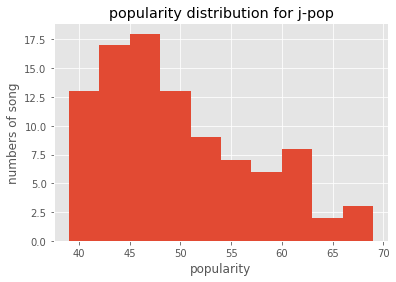

mean of popularity  49.291666666666664
min of popularity  39.0
max of popularity  69.0
standard deviation of popularity  7.346917243474037
skewness of popularity  0.6929780661163695
kurtosis of popularity  -0.4024851529691178


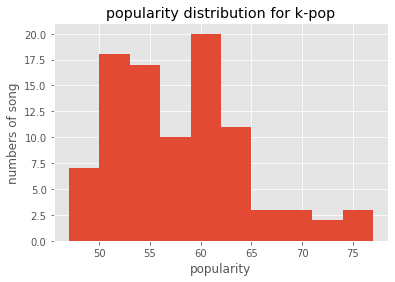

mean of popularity  57.54255319148936
min of popularity  47.0
max of popularity  77.0
standard deviation of popularity  6.559348403281751
skewness of popularity  0.7978654828632658
kurtosis of popularity  0.423048458697024


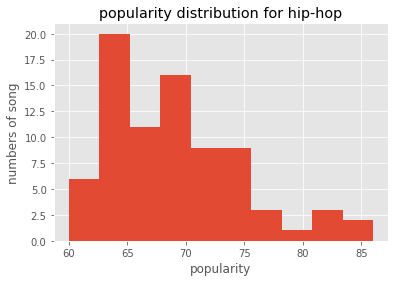

mean of popularity  68.9125
min of popularity  60.0
max of popularity  86.0
standard deviation of popularity  5.774658190333854
skewness of popularity  0.8799568929287541
kurtosis of popularity  0.45772898318637845


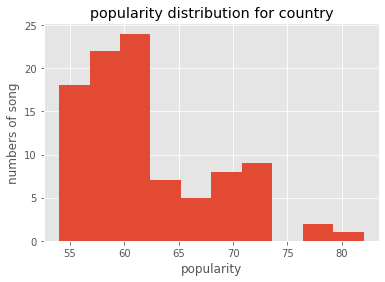

mean of popularity  61.989583333333336
min of popularity  54.0
max of popularity  82.0
standard deviation of popularity  6.072361530854658
skewness of popularity  0.9170206175208505
kurtosis of popularity  0.34562439793597965


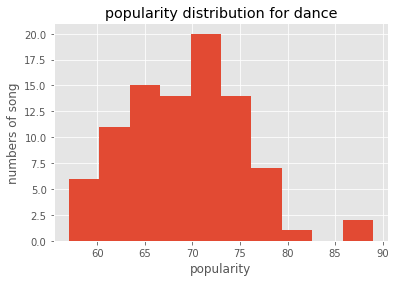

mean of popularity  69.23333333333333
min of popularity  57.0
max of popularity  89.0
standard deviation of popularity  6.14625125538991
skewness of popularity  0.5013524717490567
kurtosis of popularity  0.6098109940109495


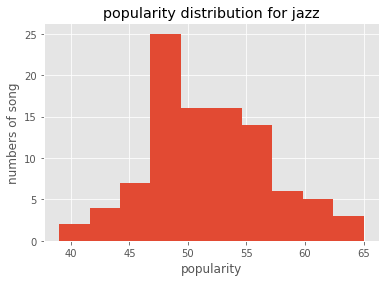

mean of popularity  51.45918367346939
min of popularity  39.0
max of popularity  65.0
standard deviation of popularity  5.133613440414755
skewness of popularity  0.25965050179938787
kurtosis of popularity  0.0816017783148899


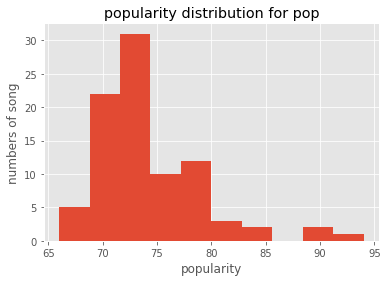

mean of popularity  74.19318181818181
min of popularity  66.0
max of popularity  94.0
standard deviation of popularity  5.014594686972034
skewness of popularity  1.3484128528030743
kurtosis of popularity  2.8739840419693037


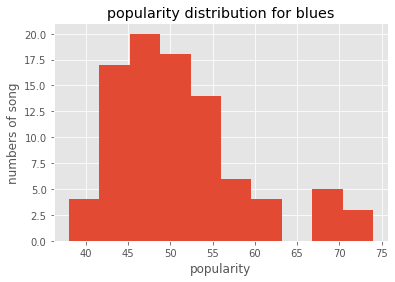

mean of popularity  51.34065934065934
min of popularity  38.0
max of popularity  74.0
standard deviation of popularity  7.820514021497537
skewness of popularity  1.0877268284029413
kurtosis of popularity  0.9821078346370067


In [8]:
data_collect = pd.DataFrame(columns=df.columns) 

for i in range(0,len(cato)):
    data_cato = df[df['genre'] == cato[i]]
    #display(data_cato.head())
        
    #作圖，繪出popularity散佈圖
    plt.hist(data_cato['popularity'],bins = 10) 
    plt.xlabel("popularity")
    plt.ylabel("numbers of song")
    title = "popularity distribution for "+cato[i]
    plt.title(title)
    plt.show()
    
    mean = data_cato['popularity'].mean()
    minimum = min(data_cato['popularity'])
    maximum = max(data_cato['popularity'])
    kurtosis = stats.kurtosis(data_cato['popularity'].values)
    skewness = stats.skew(data_cato['popularity'].values)
    std = data_cato['popularity'].std()
    

    print("mean of popularity ",mean)
    print("min of popularity ",minimum)
    print("max of popularity ",maximum)
    print("standard deviation of popularity ",std)
    print("skewness of popularity ",skewness)
    print("kurtosis of popularity ",kurtosis)
    
    data_collect = pd.concat([data_collect,data_cato])
    
# 看每種歌曲的popularity相關資料
summary = data_collect[['popularity','genre']].groupby('genre').describe()

In [9]:
summary

popularity                                                    
             count       mean       std   min    25%   50%   75%   max
genre                                                                 
blues         91.0  51.340659  7.820514  38.0  46.00  50.0  55.0  74.0
country       96.0  61.989583  6.072362  54.0  58.00  61.0  66.0  82.0
dance         90.0  69.233333  6.146251  57.0  65.00  69.0  73.0  89.0
hip-hop       80.0  68.912500  5.774658  60.0  64.75  68.0  72.0  86.0
j-pop         96.0  49.291667  7.346917  39.0  44.00  47.5  55.0  69.0
jazz          98.0  51.459184  5.133613  39.0  48.00  51.0  55.0  65.0
k-pop         94.0  57.542553  6.559348  47.0  52.00  57.0  61.0  77.0
pop           88.0  74.193182  5.014595  66.0  71.00  73.0  77.0  94.0

### 2.1 觀察每個歌曲類型的熱門程度平均數

In [10]:
data_mean = summary.iloc[:,1] #取mean欄位
data_mean = data_mean.sort_values() #由小到大排序
print(data_mean)

genre
j-pop      49.291667
blues      51.340659
jazz       51.459184
k-pop      57.542553
country    61.989583
hip-hop    68.912500
dance      69.233333
pop        74.193182
Name: (popularity, mean), dtype: float64


我們發現pop的平均熱門程度最高，j-pop最低。這個結果顯示各分類的熱門程度的平均數有明顯的差異，而不同分類的歌曲在各項特性會有差異，這讓我們好奇不同的特性會對歌曲的熱門程度造成什麼影響

### 2.2 觀察每個歌曲類型的熱門程度標準差

In [11]:
data_std = summary.iloc[:,2] #取std欄位
data_std = data_std.sort_values() #由小到大排序
print(data_std)

genre
pop        5.014595
jazz       5.133613
hip-hop    5.774658
country    6.072362
dance      6.146251
k-pop      6.559348
j-pop      7.346917
blues      7.820514
Name: (popularity, std), dtype: float64


我們發現pop的標準差最低，blues最高，這邊有一個十分有趣的現象，先前mean較高的歌曲類型通常會有較低的標準差

### 2.3 skewness and kurtosis

根據以上數據，我們發現大部分的歌曲類型的熱門程度分佈都具備right-skewed的性質，而在kurtosis方面，只有pop超過1和blues接近1，顯示他們的分佈較為集中

### 2.4 檢查Outliers

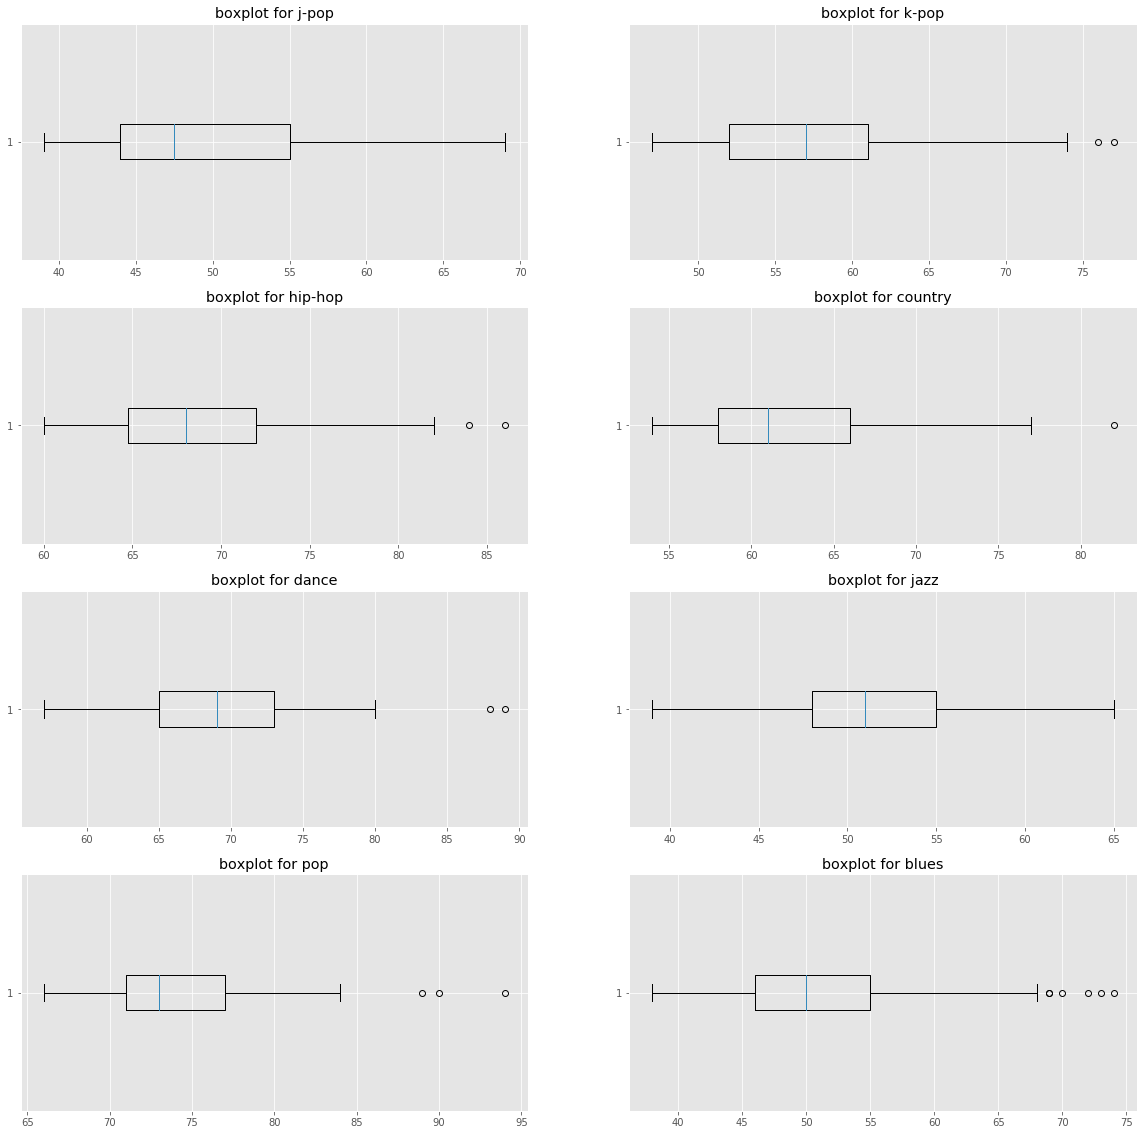

In [12]:
fig, axs = plt.subplots(int(len(cato)/2), 2, figsize=(20,20))

for i in range(0,len(cato)):
    data_cato = df[df['genre'] == cato[i]]
    #display(data_cato.head())
    
    #作圖，繪出popularity盒狀圖
    #data_cato['popularity'].plot(kind="box")
    axs[int(i/2), i%2].boxplot(data_cato['popularity'], vert=False)
    title = "boxplot for "+cato[i]
    axs[int(i/2), i%2].set_title(title)

plt.show()

從各個歌曲分類的boxplot來看，outliers並不多

**<font face="微軟正黑體">迴歸分析</font>**
---

In [43]:
df.reset_index().head

<bound method NDFrame.head of      index                      id  \
0      757  36KStm44i8gAqnQkm3PY9c   
1      758  7cy1bEJV6FCtDaYpsk8aG6   
2      759  0l4mKN097GpgeBGaoVQ1wh   
3      760  3VyJPsb2ucaaVptLSDpJNH   
4      761  5aYVqxyetmT5OYmvZCA90X   
5      762  2NVjII4zi5d4c9F7ivNYsh   
6      763  5dzTfHXcdHjxoJbpdy4DUu   
7      764  1AjJF50RFBWVS9ARRZMZNg   
8      765  1EoBy4mqDVQjSrcsuqYUv7   
9      766  7vAw4LLIms6X8ZHcbtoazz   
10     767  64ICrhXuANvFTmJutuZJ1k   
11     768  43LdgobPlcCc5g9Kmactvy   
12     769  3LQPTJEqOfljGBxmpgUnoC   
13     770  6kXGGyEPSRS1g9Ltm70jo9   
14     771  2WRk6RxETSwdsg2dhtnXxc   
15     772  2y42MmBCfEhqIkFAJs0V8Z   
16     773  0BQH5uHglCuHVImyCjOOHc   
17     774  3vPZNhkkhAupLlC9v3SrBj   
18     775  5D4yBkYPvTRQXNhOPtS6QR   
19     776  2Bs1Lw9LX8hBm70t1iGdlh   
20     777  0HOrDVS349XFcpCYsO2hAP   
21     778  1hMrI7ewBNnvDWItMScGIH   
22     779  2U7U8xdoEn74xG2umc7FHi   
23     780  5xomksmfjLCXKfriOCnSUg   
24     781  7isJy30Y

首先，我們針對每一個欄位畫出與熱門程度的散佈圖

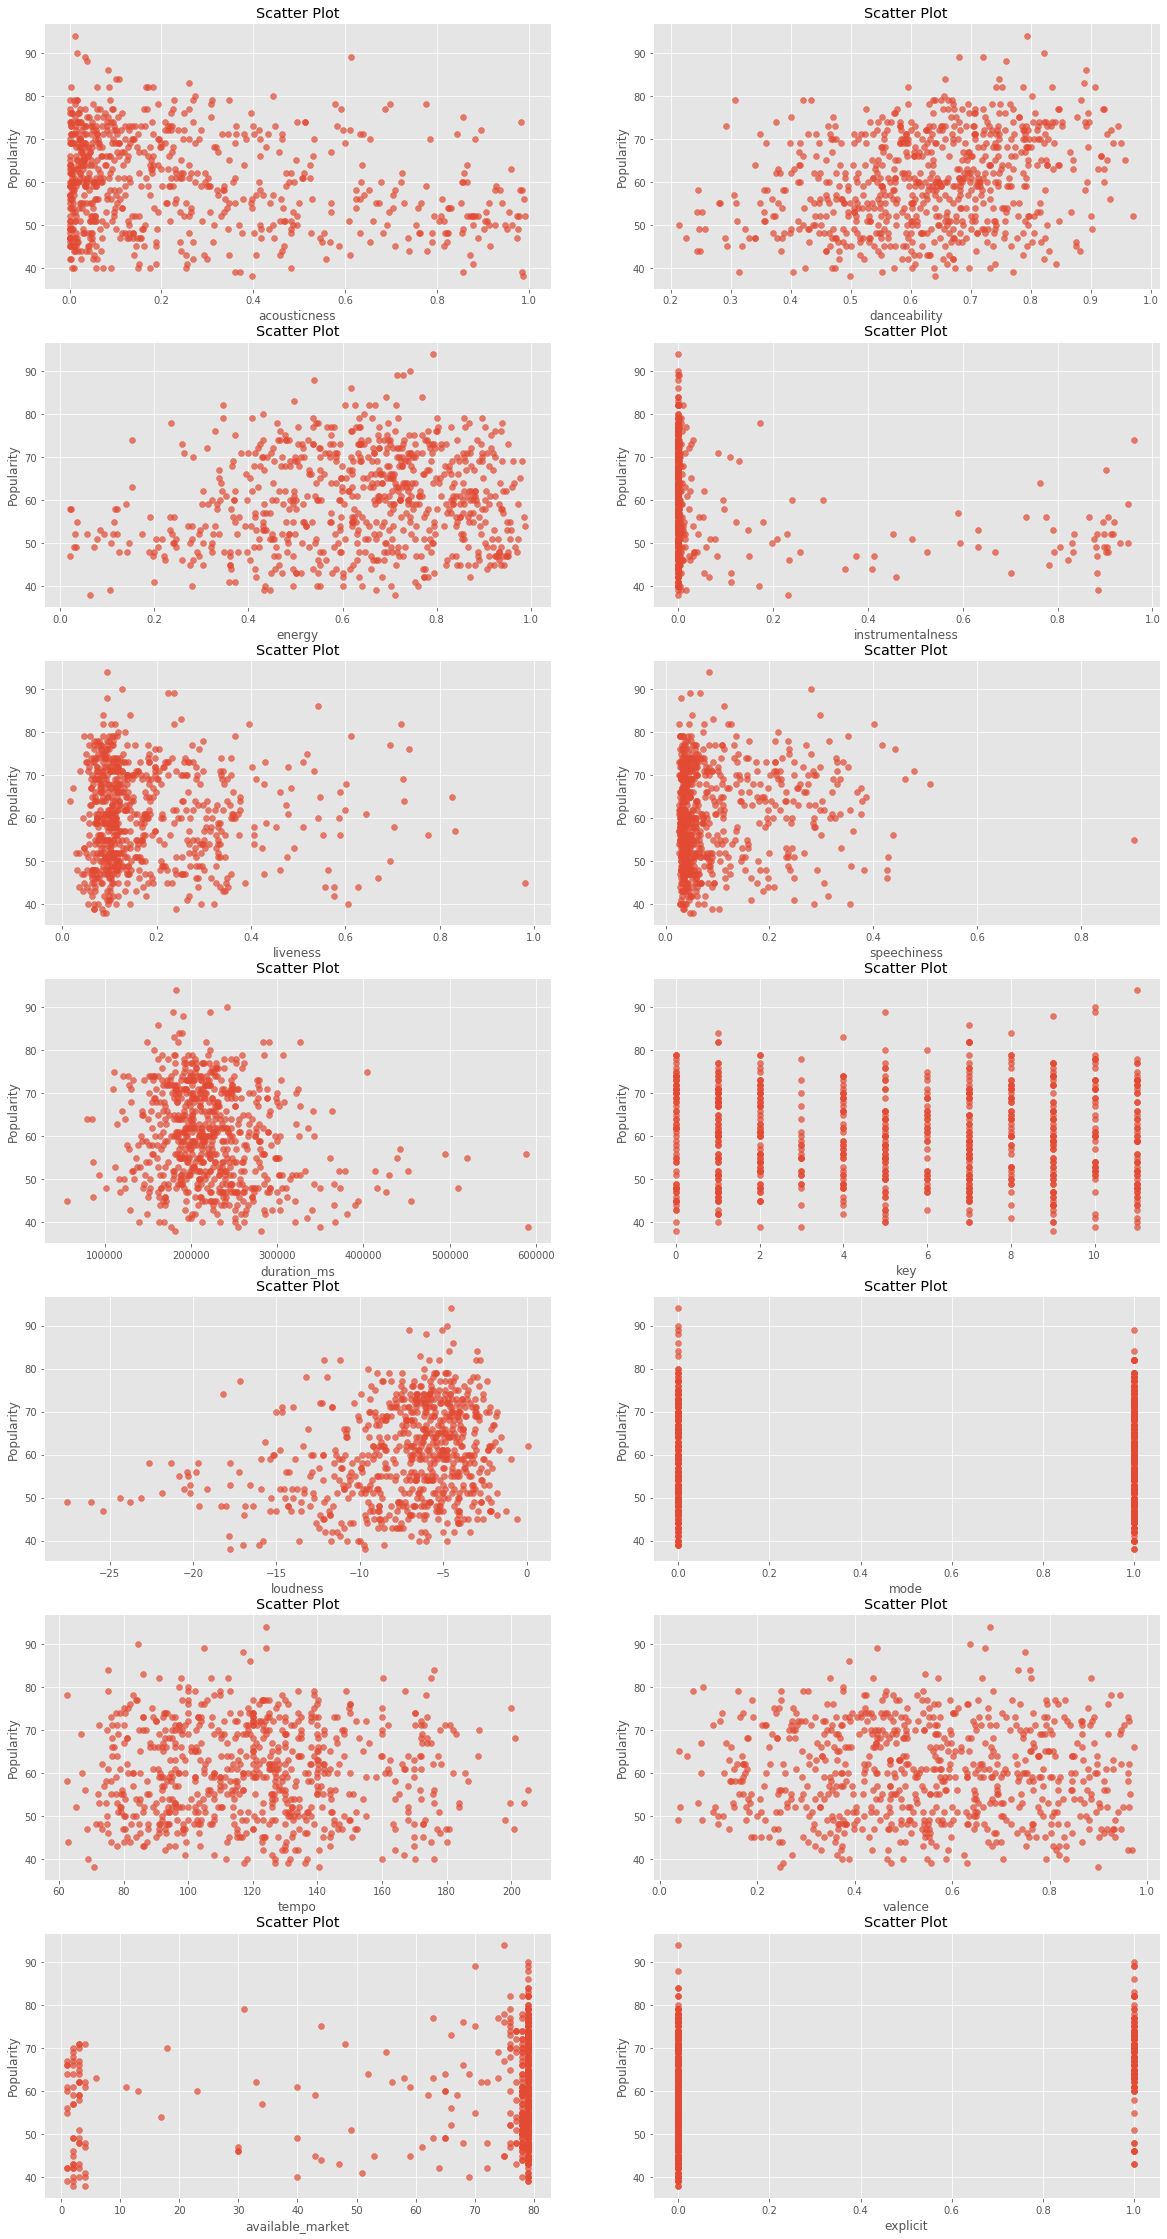

In [13]:
cato = ['j-pop', 'k-pop', 'hip-hop', 'country', 'dance', 'jazz', 'pop', 'blues']
df = df.iloc[[g in cato for g in df['genre']],:]
df = df.reset_index()

remove = ['release_date', 'genre', 'id', 'url', 'idx', 'popularity', 'name']
indepv = list(df.columns)
for feature in remove :
    indepv.remove(feature)
    
fig, axs = plt.subplots((len(indepv)+1)//2, 2, figsize=(20,40))
for i, ind in enumerate(indepv):
    axs[i//2, i%2].scatter(df[ind], df['popularity'], alpha=.7)
    axs[i//2, i%2].set_title('Scatter Plot')
    axs[i//2, i%2].set_xlabel(ind)
    axs[i//2, i%2].set_ylabel('Popularity')
plt.show()

考慮多元共線性問題，找出相關係數特別大的獨立變數

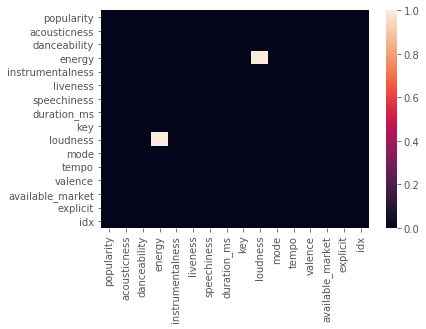

In [14]:
corr = np.sort(np.abs(df.corr()).values.reshape(-1))
sns.heatmap((np.abs(df.corr()) >= .75) & (np.abs(df.corr()) < 1))

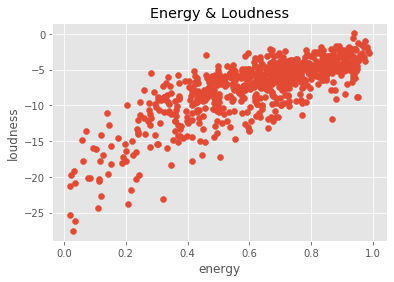

coefficient of correlation: 0.7826196887752015


In [15]:
plt.scatter(df['energy'], df['loudness'])
plt.xlabel('energy')
plt.ylabel('loudness')
plt.title('Energy & Loudness')
plt.show()
print(f"coefficient of correlation: {np.corrcoef(df['energy'], df['loudness'])[0,1]}")

由於 energy 與 loudness 的相關係數較高 (0.78)，具有 strongly positive linear relationship，因此接下來我們挑選 features 時選擇排除掉 energy

接著，我們使用 forward selection 找出合適的欄位

In [16]:
def forward_selection(input_df, depv="y", indepv = ["x1"]):
    selected = []
    candidates = indepv.copy()

    best_adjr2 = -1
    best_subset = []

    while len(candidates) > 0:
        #print("Current Candidates: ", candidates)
        tmp_indep_subset = []
        tmp_model_adjr = []
        tmp_model_nindep = []

        for acandidate in candidates:
            tmplist = selected.copy()
            tmplist.append(acandidate)
            modelstr = depv + " ~ " + "+".join(tmplist)
            result6tmp = smf.ols(modelstr, data=input_df).fit()
            #print(df18_result6tmp.summary())
            tmp_indep_subset.append(tmplist)
            tmp_model_adjr.append(result6tmp.rsquared_adj)
            tmp_model_nindep.append(len(tmplist))
        
        #find the best element
        tmp_adjr2 = np.array(tmp_model_adjr)
        tmpind = tmp_adjr2.argmax()
        this_adjr2 = tmp_adjr2[tmpind]
        selected = tmp_indep_subset[tmpind]

        if this_adjr2 <= 0:
            raise("Encounterd negative Adj R2. Stop.")
            
        #print("Current best model: ", selected)
        print(f"\rCurrent best AdjR2: {this_adjr2} / Best AdjR2: {best_adjr2}", end='')


        if this_adjr2 > best_adjr2:
            #print(" best result updated")
            best_adjr2 = this_adjr2
            best_subset = selected


        candidates = set(candidates) - set(selected)
        candidates = list(candidates)

    #print out the best result
    print("\rbest_adjr2 = ", best_adjr2)
    print("best_subset = ", best_subset)

    #run the best model again
    modelstr = depv + " ~ " + "+".join(best_subset)
    result6b = smf.ols(modelstr, data=input_df).fit()
    print(result6b.summary())
    
    return result6b

## 1. 考慮歌曲特性

In [17]:
one_hot = pd.get_dummies(df['key'], prefix = 'key_')
df_key = pd.concat([df,one_hot],axis=1)
df_key.head()

,id,name,genre,url,popularity,acousticness,danceability,energy,instrumentalness,liveness,...,key__2.0,key__3.0,key__4.0,key__5.0,key__6.0,key__7.0,key__8.0,key__9.0,key__10.0,key__11.0
757,36KStm44i8gAqnQkm3PY9c,Undecided,blues,https://open.spotify.com/track/36KStm44i8gAqnQ...,52.0,0.88900,0.701,0.296,0.000002,0.2790,...,0,0,1,0,0,0,0,0,0,0
758,7cy1bEJV6FCtDaYpsk8aG6,China Grove,blues,https://open.spotify.com/track/7cy1bEJV6FCtDaY...,68.0,0.31900,0.623,0.910,0.000448,0.0810,...,0,0,0,0,0,0,0,1,0,0
759,0l4mKN097GpgeBGaoVQ1wh,Let Go Of Your Plans,blues,https://open.spotify.com/track/0l4mKN097GpgeBG...,44.0,0.02570,0.459,0.494,0.000000,0.5560,...,0,0,0,0,0,0,0,0,0,1
760,3VyJPsb2ucaaVptLSDpJNH,I Love You,blues,https://open.spotify.com/track/3VyJPsb2ucaaVpt...,51.0,0.60800,0.559,0.446,0.000131,0.0902,...,0,0,0,0,0,0,0,0,1,0
761,5aYVqxyetmT5OYmvZCA90X,Slow Ride,blues,https://open.spotify.com/track/5aYVqxyetmT5OYm...,56.0,0.00608,0.449,0.642,0.007070,0.1750,...,1,0,0,0,0,0,0,0,0,0


In [18]:
remove = ['release_date', 'genre', 'id', 'url', 'idx', 'popularity', 'name', 'key', 'energy']
indepv = list(df_key.columns)
for feature in remove :
    indepv.remove(feature)
indepv = [f'Q("{v}")' for v in indepv]

In [19]:
result_key = forward_selection(df_key, "popularity", indepv)
result_key.save('result_key.pickle')

best_adjr2 =  0.2478757827116656604954 / Best AdjR2: 0.247875782711665666
best_subset =  ['Q("explicit")', 'Q("loudness")', 'Q("danceability")', 'Q("available_market")', 'Q("duration_ms")', 'Q("valence")', 'Q("instrumentalness")', 'Q("speechiness")', 'Q("mode")', 'Q("acousticness")', 'Q("key__8.0")', 'Q("key__0.0")', 'Q("key__10.0")', 'Q("key__2.0")']
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     18.23
Date:                Tue, 23 Jun 2020   Prob (F-statistic):           4.06e-39
Time:                        10:13:10   Log-Likelihood:                -2677.3
No. Observations:                 733   AIC:                             5385.
Df Residuals:                     718   BIC:                             5454.
Df Model:     

In [20]:
result_key = sm.load('result_key.pickle')

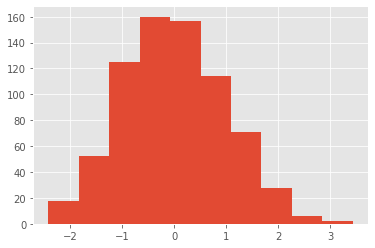

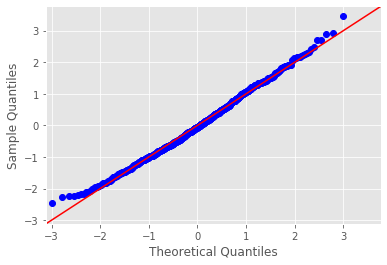

Shapiro test: statistics = 0.9948, p = 0.0142



In [21]:
resid = result_key.resid_pearson
plt.hist(resid)
sm.qqplot(resid, stats.norm, fit=True, line='45')
plt.show()
stat, p = stats.shapiro(resid)
print(f'Shapiro test: statistics = {stat:.4f}, p = {p:.4f}\n')

## 2. 考慮歌曲類型

In [22]:
one_hot = pd.get_dummies(df_key['genre'], prefix='genre_')
df_genre = pd.concat([df_key, one_hot[:]], axis=1)
df_genre.head()

,id,name,genre,url,popularity,acousticness,danceability,energy,instrumentalness,liveness,...,key__10.0,key__11.0,genre__blues,genre__country,genre__dance,genre__hip-hop,genre__j-pop,genre__jazz,genre__k-pop,genre__pop
757,36KStm44i8gAqnQkm3PY9c,Undecided,blues,https://open.spotify.com/track/36KStm44i8gAqnQ...,52.0,0.88900,0.701,0.296,0.000002,0.2790,...,0,0,1,0,0,0,0,0,0,0
758,7cy1bEJV6FCtDaYpsk8aG6,China Grove,blues,https://open.spotify.com/track/7cy1bEJV6FCtDaY...,68.0,0.31900,0.623,0.910,0.000448,0.0810,...,0,0,1,0,0,0,0,0,0,0
759,0l4mKN097GpgeBGaoVQ1wh,Let Go Of Your Plans,blues,https://open.spotify.com/track/0l4mKN097GpgeBG...,44.0,0.02570,0.459,0.494,0.000000,0.5560,...,0,1,1,0,0,0,0,0,0,0
760,3VyJPsb2ucaaVptLSDpJNH,I Love You,blues,https://open.spotify.com/track/3VyJPsb2ucaaVpt...,51.0,0.60800,0.559,0.446,0.000131,0.0902,...,1,0,1,0,0,0,0,0,0,0
761,5aYVqxyetmT5OYmvZCA90X,Slow Ride,blues,https://open.spotify.com/track/5aYVqxyetmT5OYm...,56.0,0.00608,0.449,0.642,0.007070,0.1750,...,0,0,1,0,0,0,0,0,0,0


In [23]:
remove = ['release_date', 'genre', 'id', 'url', 'idx', 'popularity', 'name', 'key', 'energy']
indepv = list(df_genre.columns)
for feature in remove :
    indepv.remove(feature)
indepv = [f'Q("{v}")' for v in indepv]

In [24]:
result_genre = forward_selection(df_genre, "popularity", indepv)
result_genre.save('result_genre.pickle')

best_adjr2 =  0.6870253246036997722234 / Best AdjR2: 0.6870253246036997
best_subset =  ['Q("genre__pop")', 'Q("genre__dance")', 'Q("genre__hip-hop")', 'Q("genre__country")', 'Q("genre__k-pop")', 'Q("available_market")', 'Q("genre__j-pop")', 'Q("instrumentalness")', 'Q("key__6.0")', 'Q("key__5.0")', 'Q("speechiness")', 'Q("danceability")', 'Q("key__11.0")', 'Q("liveness")', 'Q("key__7.0")']
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 23 Jun 2020   Prob (F-statistic):          1.77e-172
Time:                        10:13:39   Log-Likelihood:                -2355.4
No. Observations:                 733   AIC:                             4743.
Df Residuals:                     717   BIC:          

In [25]:
result_genre = sm.load('result.genre.pickle')

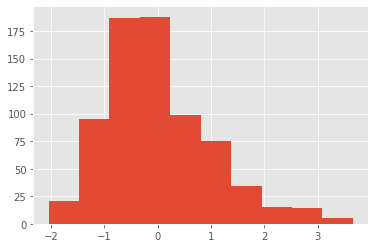

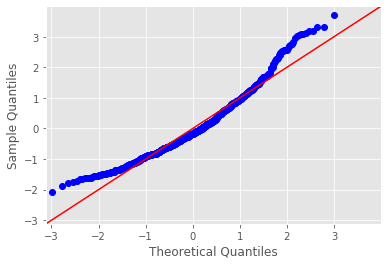

Shapiro test: statistics = 0.9543, p = 0.0000



In [26]:
resid = result_genre.resid_pearson
plt.hist(resid)
sm.qqplot(resid, stats.norm, fit=True, line='45')
plt.show()
stat, p = stats.shapiro(resid)
print(f'Shapiro test: statistics = {stat:.4f}, p = {p:.4f}\n')

## 3. 考慮交叉項

In [27]:
gen_col = ['genre__blues', 'genre__country', 'genre__dance', 'genre__hip-hop', 'genre__j-pop', 'genre__jazz', 'genre__k-pop', 'genre__pop']
remove = ['release_date', 'genre', 'id', 'url', 'idx', 'popularity', 'name', 'key', 'energy']
col = [c for c in df_genre.columns if c not in gen_col and c not in remove]

df_inter = df_genre.copy()
df_inter = df_inter.reset_index()
for g in gen_col:
    inter = pd.DataFrame(df_genre[col].values * df_genre[g].values.reshape(-1,1), columns=[c+'_'+g  for c in col])
    new_col = np.hstack([np.array(df_inter.columns), np.array(inter.columns)])
    df_inter = pd.concat([df_inter, inter], ignore_index=True, axis=1)
    df_inter.columns = new_col
del df_inter['index']
df_inter.head()

,id,name,genre,url,popularity,acousticness,danceability,energy,instrumentalness,liveness,...,key__2.0_genre__pop,key__3.0_genre__pop,key__4.0_genre__pop,key__5.0_genre__pop,key__6.0_genre__pop,key__7.0_genre__pop,key__8.0_genre__pop,key__9.0_genre__pop,key__10.0_genre__pop,key__11.0_genre__pop
0,36KStm44i8gAqnQkm3PY9c,Undecided,blues,https://open.spotify.com/track/36KStm44i8gAqnQ...,52.0,0.88900,0.701,0.296,0.000002,0.2790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7cy1bEJV6FCtDaYpsk8aG6,China Grove,blues,https://open.spotify.com/track/7cy1bEJV6FCtDaY...,68.0,0.31900,0.623,0.910,0.000448,0.0810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0l4mKN097GpgeBGaoVQ1wh,Let Go Of Your Plans,blues,https://open.spotify.com/track/0l4mKN097GpgeBG...,44.0,0.02570,0.459,0.494,0.000000,0.5560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3VyJPsb2ucaaVptLSDpJNH,I Love You,blues,https://open.spotify.com/track/3VyJPsb2ucaaVpt...,51.0,0.60800,0.559,0.446,0.000131,0.0902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5aYVqxyetmT5OYmvZCA90X,Slow Ride,blues,https://open.spotify.com/track/5aYVqxyetmT5OYm...,56.0,0.00608,0.449,0.642,0.007070,0.1750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
remove = ['release_date', 'genre', 'id', 'url', 'idx', 'popularity', 'name', 'key', 'energy']
indepv = list(df_inter.columns)
for feature in remove :
    indepv.remove(feature)
indepv = [f'Q("{v}")' for v in indepv]

In [ ]:
result_inter = forward_selection(df_inter, "popularity", indepv)
result_inter.save('result_inter.pickle')

In [30]:
result_inter = sm.load('result_inter.pickle')

In [ ]:
result_inter.summary()

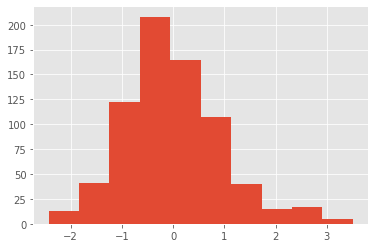

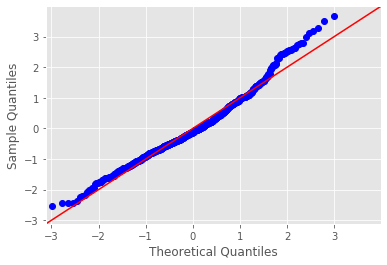

Shapiro test: statistics = 0.9767, p = 0.0000



In [31]:
resid = result_inter.resid_pearson
plt.hist(resid)
sm.qqplot(resid, stats.norm, fit=True, line='45')
plt.show()
stat, p = stats.shapiro(resid)
print(f'Shapiro test: statistics = {stat:.4f}, p = {p:.4f}\n')

**<font face="微軟正黑體">假設檢定</font>**
---

### 1.檢驗各種歌曲類型的熱們程度及各項獨立變數是否為常態分佈

### 對每個歌曲類型的每個獨立變數的 shapiro-wilk test:
### $H_0$:此項變數為常態分佈
### $H_1$:此變數非常態分佈

In [37]:
df['genre']

757       blues
758       blues
759       blues
760       blues
761       blues
762       blues
763       blues
764       blues
765       blues
766       blues
767       blues
768       blues
769       blues
770       blues
771       blues
772       blues
773       blues
774       blues
775       blues
776       blues
777       blues
778       blues
779       blues
780       blues
781       blues
782       blues
783       blues
784       blues
785       blues
786       blues
787       blues
788       blues
789       blues
790       blues
791       blues
792       blues
793       blues
794       blues
795       blues
796       blues
797       blues
798       blues
799       blues
800       blues
801       blues
802       blues
803       blues
804       blues
805       blues
806       blues
807       blues
808       blues
809       blues
810       blues
811       blues
812       blues
813       blues
814       blues
815       blues
816       blues
817       blues
818       blues
819     

In [33]:
a = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'duration_ms', 'key', 'loudness', 'tempo', 'valence', 'available_market']

group = []
group.append(' ')
group.append('j-pop')
group.append('k-pop')
group.append('pop')
group.append('hip-hop')
group.append('dance')
group.append('jazz')
group.append('blues')
group.append('country')

df['group'] = 0
for i in range(df.shape[0]):
    for j in range(len(group)):
        if df['genre'][i] in group[j]:
            df['group'][i] = j
df_group = []
for i in range(len(group) + 1):
    df_group.append(df[df['group'] == i])

KeyError: 0

In [ ]:
def all_normality_test():
    count = 0
    for i in range(1,len(group)):
        print('\n\nfor %s:\ntest normality of all attribute\n' % (group[i]))
        for j in range(len(a)):
            print('%s of %s' % (a[j], group[i]))
            fig, axs = plt.subplots(1, 2, figsize=(10,3))
            axs[0].hist(df_group[i][a[j]])
            sm.qqplot(df_group[i][a[j]], stats.norm, fit=True, line='45', ax=axs[1])
            plt.show()
            stat, p = stats.shapiro(df_group[i][a[j]])
            print(f'Shapiro test: statistics = {stat:.4f}, p = {p:.4f}\n')
            if p < 0.05 :
                count = count + 1
    print('%d/%d of variables are not normally distributed' % (count, len(a)*(len(group)-1)))

In [ ]:
compare_all_mean('popularity')

### 3.檢驗相近歌曲類型的獨立變數差異

### 1. j-pop, k-pop and pop

In [ ]:
compare_mean(a[1],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖可以發現，acousticness 在這三種歌曲類型間的分佈並沒有顯著差異，並可以由此推測不同地區間的 pop 類型歌曲所使用的樂器種類並無太大的差異。

In [ ]:
a = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'duration_ms', 'loudness', 'tempo', 'valence', 'available_market']

group = []
group.append(' ')
group.append('j-pop')
group.append('k-pop')
group.append('pop')
group.append('hip-hop')
group.append('dance')
group.append('jazz')
group.append('blues')
group.append('country')

df['group'] = 0
for i in range(df.shape[0]):
    for j in range(len(group)):
        if df['genre'][i] in group[j]:
            df['group'][i] = j
df_group = []
for i in range(len(group) + 1):
    df_group.append(df[df['group'] == i])

In [ ]:
def all_normality_test(print_all):
    pri = 1000
    if print_all == False:
        pri = 5
    count = 0
    for i in range(1,len(group)):
        if pri > 0:
            print('\n\nfor %s:\ntest normality of all attribute\n' % (group[i]))
        for j in range(len(a)):
            if pri > 0:
                print('%s of %s' % (a[j], group[i]))
                fig, axs = plt.subplots(1, 2, figsize=(10,3))
                axs[0].hist(df_group[i][a[j]])
                sm.qqplot(df_group[i][a[j]], stats.norm, fit=True, line='45', ax=axs[1])
                plt.show()
            stat, p = stats.shapiro(df_group[i][a[j]])
            if pri > 0:
                print(f'Shapiro test: statistics = {stat:.4f}, p = {p:.4f}\n')
            if p < 0.05 :
                count = count + 1
            pri = pri - 1
            if pri == 0:
                print('*************************************************************************************************************************\n')
                print('******************* we only show five results of the normality test since there are too many of them. *******************\n')
                print('*************************** modify the only input \'print_all\' to TRUE to see all results. *****************************\n')
                print('*************************************************************************************************************************\n')
    print('%d/%d of variables are not normally distributed' % (count, len(a)*(len(group)-1)))

In [ ]:
all_normality_test()

有84/104的獨立變數並非常態分佈，因此我們後面都會使用nonparamatric statistic來做假設檢定

### 2.檢驗各種歌曲類型之間的熱門程度是否有差
### $H_0$:所有的歌曲類型有相同的熱門程度
### $H_1$:有些歌曲類型的熱門程度與其他類型不同

In [ ]:
def compare_mean(attribute, index, alt = 'greater'):
    if len(index) == 2:
        stat, p = stats.mannwhitneyu(df_group[index[0]][attribute],df_group[index[1]][attribute],alternative = alt)
        if p < 0.05:
            print('conduct Wilcoxon rank sum test\n')
            print('Null hypothesis: the population location(distribution) of %s of %s and %s music are the same' % (attribute, group[index[0]], group[index[1]]))
            print('Alternative hypothesis: %s of %s music is %s than %s music\n' % (attribute, group[index[0]], alt, group[index[1]]))
            print('statistics = %f, p = %f\n' % (stat, p))
    elif len(index) == 3:
        print(attribute,':\n')
        print('conduct Kruskal-Wallis Test\n')
        Group1 = []
        Group2 = []
        for i in range(len(index)):
            Group1.append(df_group[index[i]][attribute])
            Group2.append(group[index[i]])
        stat, p = stats.kruskal(Group1[0], Group1[1],Group1[2])
        print('statistics = %f, p = %f\n\n' % (stat, p))
        plt.boxplot(Group1, labels = Group2,vert = 0)
        plt.show()
        if p < 0.05:
            print('\n')
            for j in range(3):
                for k in range(3):
                    if j != k:
                        compare_mean(attribute,[index[j],index[k]])
    else :
        print('len(index) must be less than 4')
def compare(index):
    for i in range(len(a)):
        compare_mean(a[i], index)
        print('\n\n')

In [ ]:
def compare_all_mean(attribute):
    print(attribute,':\n')
    print('conduct Kruskal-Wallis Test\n')
    Group1 = []
    Group2 = []
    for i in range(1,len(group)):
        Group1.append(df_group[i][attribute])
        Group2.append(group[i])
    stat, p = stats.kruskal(Group1[0], Group1[1], Group1[2], Group1[3], Group1[3], Group1[4], Group1[5], Group1[6], Group1[7])
    print('statistics = %f, p = %f\n\n' % (stat, p))
    plt.boxplot(Group1, labels = Group2,vert = 0)
    plt.show()
def compare_all():
    for i in range(len(a)):
        compare_all_mean(a[i])
        print('\n\n')

In [ ]:
def index(genre):
    for i in range(len(group)):
        if group[i] == genre:
            return i

In [ ]:
compare_all_mean('popularity')

### 3.檢驗相近歌曲類型的獨立變數差異

### 1. j-pop, k-pop and pop

In [ ]:
compare_mean(a[0],[index('j-pop'),index('k-pop'),index('pop')])

In [ ]:
compare_mean(a[1],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖可以發現，danceablity 在這三種歌曲類型間的分佈並沒有顯著差異，並可以由此推測不同地區間的 pop 類型歌曲之間的節奏對於跳舞的影響並無太大的差異。

In [ ]:
compare_mean(a[3],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，k-pop 在 energy 顯著大於其他兩個歌曲類型，由此可推測近年韓國流行歌曲多以舞曲為主打，相較於其他地區流行歌曲有較高的 energy。

In [ ]:
compare_mean(a[4],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，三個歌曲類型在 instrumentalness 方面都非常接近 0，而其中又以 k-pop 顯著低於其他兩個類型。由此可以推測各地區的 pop 類型歌曲仍以有人聲歌曲為主，而其中又以 k-pop 更為顯著。

In [ ]:
compare_mean(a[5],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，k-pop 在 liveness 方面顯著高於 pop。由此可以推測 k-pop 類型歌曲在 Spotify 上相較 pop 可能有較多的現場演唱版本。

In [ ]:
compare_mean(a[6],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，三個類型在 speechiness 都普遍低於 0.33，由此可知大部分這三類的歌曲都以音樂為主，其中又以 k-pop 在 speechiness 方面顯著大於其他兩個歌曲類型，推測 k-pop 類型在歌曲中加入了較多的歌詞部分。

In [ ]:
compare_mean(a[7],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，j-pop 在 duration_ms 方面顯著高於其他兩個音樂類型。由此推測可能是因為 j-pop 類型歌曲相較於其他兩類型在間奏及尾奏有更多的變化，進而拉長歌曲時間。

In [ ]:
compare_mean(a[8],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，k-pop 在 loudness 顯著大於其他兩個歌曲類型，由此可推測是因為近年韓國流行歌曲多以舞曲為主打，相較於其他地區流行歌曲有較高的響度。

In [ ]:
compare_mean(a[9],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖可以發現，tempo 在這三種歌曲類型間的分佈並沒有顯著差異，可以由此推測不同地區間的 pop 類型歌曲之間的節奏並無太大的差異。

In [ ]:
compare_mean(a[10],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖可以發現，j-pop 在 valence 方面顯著高於其他兩個類型。由此可推測 j-pop 類型歌曲相較於其他兩類型歌曲給人比較正向的感覺。

In [ ]:
compare_mean(a[11],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖可以發現，available_market 在這三種歌曲類型間的分佈並沒有顯著差異，由此可以推測這三種 pop 類型的歌曲在全球音樂市場上有相同的推廣程度。

### pop, hip-hop and dance

In [ ]:
compare_mean(a[1],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖可以發現，acousticness 在這三種歌曲類型間的分佈並沒有顯著差異，由此可以推測這三種類型的歌曲在電子處理的部分沒有顯著差異。

In [ ]:
compare_mean(a[3],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖可以發現，hip-hop 類型的歌曲在 danceability 這項特性顯著高於其他兩個類型。由此可以推測嘻哈類型的歌曲普遍擁有比較動感的律動。

In [ ]:
compare_mean(a[4],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，dance 類型的歌曲在 energy 這項特性顯著高於其他兩個類型。推測是因為舞曲類型的歌通常聽起來會有較有活力，令人能夠隨之跳舞。

In [ ]:
compare_mean(a[5],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，三種類型的歌曲在 instrumentalness 這項特性並沒有顯著差異。由此可推論 dance、hip-hop 和 pop 的歌曲擁有相同程度的人聲。

In [ ]:
compare_mean(a[6],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，三種類型的歌曲在 liveness 這項特性並沒有顯著差異。由此可推論 dance、hip-hop 和 pop 類型在 Spotify 中收錄的歌曲為現場錄音的程度相同。

In [ ]:
compare_mean(a[7],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，hip-hop 類型的歌曲在 speechiness 這項特性非常顯著大於其他兩個類型，由此可推論是因為 hip-hop 的歌曲包含許多饒舌片段，因而大幅增加了歌詞所佔的比例。

In [ ]:
compare_mean(a[7],[index('pop'),index('hip-hop'),index('dance')])

根據上圖以及檢定結果可以發現，dance 類型的歌曲在 duration_ms 這項特性顯著大於其他兩個類型，由此可推論 dance 的歌曲以跳舞為導向所創作，因而會有較長的曲長。

In [ ]:
compare_mean(a[8],[index('pop'),index('hip-hop'),index('dance')])

根據上圖以及檢定結果可以發現，dance 類型的歌曲在 loudness 這項特性顯著高於其他兩個類型。推測是因為舞曲類型的歌通常聽起來會有較有活力及能量，故也可能有較大的響度。

In [ ]:
compare_mean(a[9],[index('pop'),index('hip-hop'),index('dance')])

根據上圖以及檢定結果可以發現，三種類型的歌曲在 tempo 這項特性並沒有顯著差異。由此可推論 dance、hip-hop 和 pop 類型的歌曲在節奏上並無顯著差異。

In [ ]:
compare_mean(a[10],[index('pop'),index('hip-hop'),index('dance')])

根據上圖以及檢定結果可以發現，三種類型的歌曲在 valence 這項特性並沒有顯著差異。由此可推論 dance、hip-hop 和 pop 類型在正向性方面沒有太大的差異。

In [ ]:
compare_mean(a[11],[index('pop'),index('hip-hop'),index('dance')])

根據上圖以及檢定結果可以發現，hip-hop 類型的歌曲在 available_market 這項特性顯著高於其他兩個類型。由此可推測嘻哈歌曲在全球市場相較於其他兩類型更為普及，顯示嘻哈文化已經具備相當的傳播程度。

### jazz, blues and country

In [ ]:
compare_mean(a[0],[index('jazz'),index('blues'),index('country')])

根據上圖以及檢定結果可以發現，jazz 類型的歌曲在 acousticness 這項特性顯著高於其他兩個類型。由此可推測 jazz 類型的歌曲相較於 blues 和 country 使用了更多如吉他等不插電樂器。

In [ ]:
compare_mean(a[1],[index('j-pop'),index('k-pop'),index('pop')])

In [ ]:
compare_mean(a[2],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，country 類型的歌曲在 danceability 這項特性顯著高於 blues。可由此推測是因為相較於 country 歌曲，blues 歌曲有較為憂鬱的曲風，而 country 則較為輕快。

In [ ]:
compare_mean(a[3],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，country 類型的歌曲在 energy 這項特性顯著高於其他兩個類型。由此可推測是因為 jazz 和 blues 歌曲大部分是較為抒情的曲風，而 country 相比之下則較為輕快。

In [ ]:
compare_mean(a[4],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，blues 類型的歌曲在 instrumentalness 這項特性顯著高於 country，而 jazz 更是顯著高於其他兩個類型。由此推測是因為 jazz 和 blues 歌曲使用大量薩克斯風、口琴等樂器營造曲風。

In [ ]:
compare_mean(a[5],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，三種類型的歌曲在 liveness 這項特性並沒有顯著差異。由此可推論 country、blues 和 jazz 類型在 Spotify 中收錄的歌曲為現場錄音的程度相同。

In [ ]:
compare_mean(a[6],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，country 類型的歌曲在 speechiness 這項特性顯著低於其他兩個類型。由此可推論 country 類型歌曲相較於 jazz 和 blues 有較低的言語性。

In [ ]:
compare_mean(a[7],[index('j-pop'),index('k-pop'),index('pop')])

根據上圖以及檢定結果可以發現，三種類型的歌曲在 duration_ms 這項特性並沒有顯著差異。由此可推論 country、blues 和 jazz 類型在歌曲長度上並沒有明顯的差異。

In [ ]:
compare_mean(a[8],[index('jazz'),index('blues'),index('country')])

根據上圖以及檢定結果可以發現，country 類型的歌曲在 loudness 這項特性顯著高於其他兩個類型。由此可推測是因為 jazz 和 blues 歌曲大部分是較為抒情的曲風，相較於 country 響度會比較低。

In [ ]:
compare_mean(a[9],[index('jazz'),index('blues'),index('country')])

根據上圖以及檢定結果可以發現，country 類型的歌曲在 loudness 這項特性顯著高於其他兩個類型。由此可推測是因為 jazz 和 blues 歌曲大部分是較為抒情的曲風，相較於 country 響度會比較低。

In [ ]:
compare_mean(a[10],[index('jazz'),index('blues'),index('country')])

根據上圖以及檢定結果可以發現，jazz 類型的歌曲在 valence 這項特性顯著低於其他兩個類型。由此可推測是因為 jazz 的歌曲相較 blues 及 country 有更憂鬱的情緒也更抒情，因此在正向性上比較低。

In [ ]:
compare_mean(a[11],[index('jazz'),index('blues'),index('country')])

根據上圖可以發現，available_market 在這三種歌曲類型間的分佈並沒有顯著差異，由此可以推測 country、blues 及 jazz 的歌曲在全球音樂市場上有相同的推廣程度。

**<font face="微軟正黑體">結論與建議</font>**
---